In [ ]:
import gc
import json
import os
import random
import re
import sys
from collections import defaultdict, Counter

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import polars as pl
import scipy.sparse as sp
from gensim.models.poincare import PoincareModel
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from tqdm import tqdm

In [2]:
random_state = 42
random.seed(random_state)

# **Item features**

In [3]:
img_feats_path = "/kaggle/input/ozon-data/ml_ozon_recsys_train_final_apparel_items_data/ml_ozon_recsys_train_final_apparel_items_data"

filepaths = os.listdir(img_feats_path)
item_feats_filepaths = sorted([os.path.join(img_feats_path, filepath) for filepath in filepaths if filepath.endswith(".parquet")])

In [4]:
p = pl.read_parquet(item_feats_filepaths[0])

In [5]:
#defining apparel categories ids and collecting attributes statistic
apparel_categories = set()
attributes_statistic = defaultdict(lambda: defaultdict(int))
n_items = 0

for filepath in tqdm(item_feats_filepaths):
    df = pl.read_parquet(filepath).to_pandas()
    no_dup_ids = df.drop(columns=["attributes", "fclip_embed"]).drop_duplicates().index
    df = df.loc[no_dup_ids]
    df_categories = df['catalogid'].unique()

    n_items += len(df)
    
    apparel_categories |= set(df_categories)
    df_attributes = np.concatenate(df['attributes'].values)

    for attribute in df_attributes:
        attribute_name = attribute['attribute_name']
        attribute_value = attribute['attribute_value']

        attributes_statistic[attribute_name][attribute_value] += 1
        attributes_statistic[attribute_name]['total_number'] += 1
    
    del df, df_categories, no_dup_ids, df_attributes
    gc.collect()

100%|██████████| 100/100 [12:51<00:00,  7.71s/it]


In [6]:
#creating attribute statistic dataset
rows = []
for attr_name, values_dict in attributes_statistic.items():
    total = values_dict['total_number']
    for value, count in values_dict.items():
        if value != 'total_number':
            rows.append({
                'attribute': attr_name,
                'value': value,
                'count': count,
                'total_in_attr': total,
                'freq' : count / total
            })

as_df = pd.DataFrame(rows)

In [7]:
attr_freq_thresh = 0.05
attr_val_freq_thresh = 0.01
mask = np.ones(len(as_df)).astype(bool)

annotation_ids = np.where(as_df['attribute']=="Annotation")
name_ids = np.where(as_df['attribute']=="Name")

to_drop = np.where(
    (as_df['total_in_attr'] / n_items) < attr_freq_thresh
)

low_freq = np.where(
    as_df['freq'] < attr_val_freq_thresh
)

mask[annotation_ids] = False
mask[name_ids] = False
mask[to_drop] = False
mask[low_freq] = False

as_df = as_df[mask]

In [8]:
as_df.shape

(368, 5)

In [9]:
as_df['attribute'] = as_df['attribute'].str.lower().str.strip().str.replace(r'[^а-яёa-z0-9\s]', '', regex=True)
as_df['value'] = as_df['value'].str.lower().str.strip().str.replace(r'[^а-яёa-z0-9\s]', '', regex=True)

In [10]:
as_df

,attribute,value,count,total_in_attr,freq
1,type,футболка,844891,6342029,0.133221
5,type,босоножки,75334,6342029,0.011879
6,type,юбка,71666,6342029,0.011300
7,type,кроссовки,423665,6342029,0.066803
8,type,сумка на плечо,112744,6342029,0.017777
...,...,...,...,...,...
4600251,footlength,27,16735,484997,0.034505
4600253,footlength,29,8086,484997,0.016672
4600254,footlength,275,12619,484997,0.026019
4600257,footlength,26,21716,484997,0.044776


In [11]:
as_df.to_csv("selected_attributes.csv", index=False)

In [12]:
#value-coords dict
value_coords = defaultdict()

k = 0

for attribute in as_df['attribute'].unique():
    attribute_df = as_df[as_df['attribute']==attribute]

    value_coords["no_" + attribute] = k
    k += 1
    value_coords["other_" + attribute] = k
    k += 1

    for value in attribute_df['value'].unique():
        value_coords[attribute + "_"+ value] = k
        k += 1

    del attribute_df
    gc.collect()

with open("value_coords.json", "w", encoding="utf-8") as f:
    json.dump(value_coords, f, ensure_ascii=False, indent=4)

In [13]:
#counting model ids
model_counts = Counter()

for filepath in tqdm(item_feats_filepaths):
    df = pd.read_parquet(filepath)
    
    model_ids = Counter(
        dict(
            df.groupby(
                'item_id'
            ).agg(
                {'model_id' : 'first'}
            ).drop_duplicates()['model_id'].value_counts()
        )
    )
    
    model_counts += model_ids
    
    del df, model_ids
    gc.collect()

100%|██████████| 100/100 [09:28<00:00,  5.69s/it]


In [14]:
sorted_freq = sorted(model_counts.values(), reverse=True)

<BarContainer object of 50000 artists>

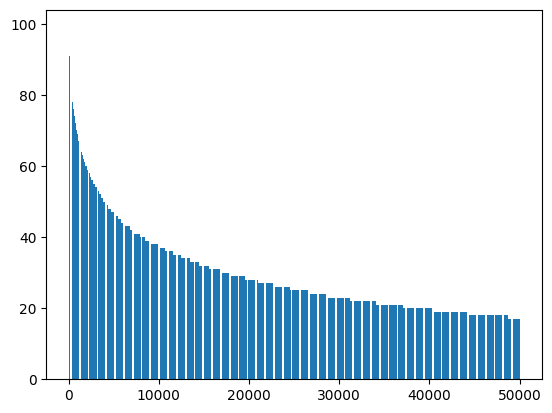

In [18]:
plt.bar(np.arange(0, 50000), sorted_freq[:50000])

<BarContainer object of 5000 artists>

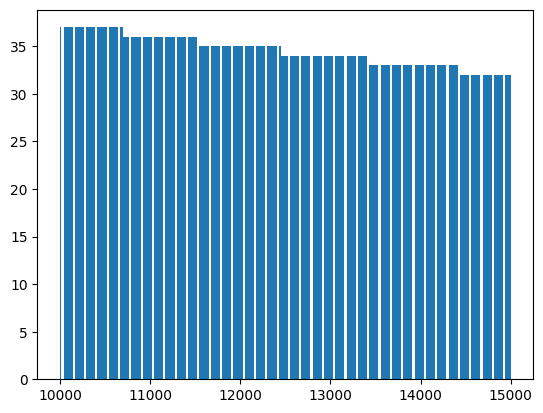

In [19]:
plt.bar(np.arange(10000, 15000), sorted_freq[10000:15000])

In [20]:
sorted_model_counts = sorted(model_counts.items(), key=lambda t: model_counts[t[0]], reverse=True)

#defining constants
n_models = len(model_counts)
total_popularity = sum(model_counts.values())

#for normalization
max_pop = sorted_model_counts[0][1]
max_log_pop = np.log1p(max_pop)
min_pop = sorted_model_counts[-1][1]
min_log_pop = np.log1p(min_pop)

#for standartization
mean_pop = total_popularity / n_models
std_pop = np.sqrt(
    sum((p - mean_pop)**2 for p in model_counts.values()) / n_models
)

log_pop = np.log1p(list(model_counts.values()))
mean_log_pop = np.mean(log_pop)
std_log_pop = np.std(log_pop)

tail_threshold = 688690

#calculating zipf deviation
model_zipf_devs = {}

for rank, (model_id, popularity) in enumerate(sorted_model_counts, 1):
    expected_popularity = max_pop / rank
    zipf_ratio = popularity / expected_popularity
    zipf_deviation = np.log(zipf_ratio)
    model_zipf_devs[model_id] = zipf_deviation

max_zipf_dev = max(model_zipf_devs.values())
min_zipf_dev = min(model_zipf_devs.values())

#creating zipf features for each model id
zipf_feats = {}

for rank, (model_id, popularity) in enumerate(sorted_model_counts, 1):
    feats = {}

    feats['norm_pop'] = (popularity - min_pop) / (max_pop - min_pop)
    feats['norm_inv_rk'] = 1 - (rank - 1) / n_models
    feats['norm_log_pop'] = (np.log1p(popularity) - min_log_pop) / (max_log_pop - min_log_pop)
    
    feats['log_rk'] = np.log1p(rank)
    feats['rel_pop'] = popularity / total_popularity

    feats['norm_zipf_dev'] = (model_zipf_devs[model_id] - min_zipf_dev) / (max_zipf_dev - min_zipf_dev)
    feats['z_score'] = (popularity - mean_pop) / std_pop
    feats['zipf_z_score'] = (np.log1p(popularity) - mean_log_pop) / std_log_pop

    feats['tailness'] = max(0, rank - tail_threshold) / (n_models - tail_threshold)
    
    zipf_feats[model_id] = feats

with open("zipf_feats.json", "w", encoding="utf-8") as f:
    json.dump(zipf_feats, f, ensure_ascii=False, indent=4)

# **Item categories preparation**

In [21]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

gensim_logger = logging.getLogger('gensim')
gensim_logger.setLevel(logging.INFO)
gensim_logger.addHandler(logging.StreamHandler(sys.stdout))

In [22]:
def evaluate_poincare_metrics(
    model,
    edges,
    k_values = [1, 5, 10],
    exclude_children = True
):
    
    parent_dict = {}
    children_dict = {}
    all_nodes = set()
    
    for child, parent in edges:
        parent_dict[child] = parent
        all_nodes.update([child, parent])
        if parent not in children_dict:
            children_dict[parent] = set()
        children_dict[parent].add(child)
    
    available_nodes = set(model.kv.index_to_key)
    test_nodes = [node for node in parent_dict.keys() 
                 if node in available_nodes and parent_dict[node] in available_nodes]
    
    ranks = []
    
    for child in test_nodes:
        true_parent = parent_dict[child]
        child_vec = model.kv[child]
        
        candidates = []
        for node in available_nodes:
            if node == child:
                continue
            if exclude_children:
                if node in children_dict.get(child, set()):
                    continue
            candidates.append(node)
        
        if not candidates:
            continue
        
        distances = model.kv.distances(child_vec, candidates)
        sorted_nodes = [node for _, node in sorted(zip(distances, candidates))]
        
        try:
            rank = sorted_nodes.index(true_parent) + 1
        except ValueError:
            rank = len(candidates) + 1
        ranks.append(rank)
    
    metrics = {}
    for k in k_values:
        metrics[f'hit@{k}'] = np.mean([r <= k for r in ranks]) if ranks else 0.0
    
    metrics['mpr'] = np.mean(ranks) if ranks else float('inf')
    metrics['mrr'] = np.mean([1.0 / r for r in ranks]) if ranks else 0.0
    
    return metrics

In [23]:
categories_tree_path = "/kaggle/input/ozon-data/ml_ozon_recsys_train_final_categories_tree/ml_ozon_recsys_train_final_categories_tree/part-00000-163f9108-23d6-4fd6-98c4-7bcb73ee27e2-c000.snappy.parquet"

In [24]:
categories_tree = pd.read_parquet(categories_tree_path)

In [25]:
categories_tree

,catalogid,catalogpath,ids
0,15500,"[{'id': 15500, 'name': 'Электроника', 'fullNam...","[15500, -1]"
1,15501,"[{'id': 15501, 'name': 'Телефоны и смарт-часы'...","[15501, 15500, -1]"
2,15502,"[{'id': 15502, 'name': 'Смартфоны', 'fullName'...","[15502, 15501, 15500, -1]"
3,15511,"[{'id': 15511, 'name': 'Аксессуары для смартфо...","[15511, 15501, 15500, -1]"
4,15892,"[{'id': 15892, 'name': 'Чехлы', 'fullName': 'Ч...","[15892, 15511, 15501, 15500, -1]"
...,...,...,...
7007,39405,"[{'id': 39405, 'name': 'Екатеринбург', 'fullNa...","[39405, 55455, 55055, -1]"
7008,39406,"[{'id': 39406, 'name': 'Нижний Новгород', 'ful...","[39406, 55455, 55055, -1]"
7009,39398,"[{'id': 39398, 'name': 'Экскурсии', 'fullName'...","[39398, 55055, -1]"
7010,39792,"[{'id': 39792, 'name': 'Туры', 'fullName': 'Ту...","[39792, 55055, -1]"


In [26]:
#leave only apparel categories
edges = []
id_chains = categories_tree['ids'].values
for id_catalog in id_chains:
    child = id_catalog[0]
    parent = id_catalog[1]

    pair = (parent, child)
    edges.append(pair)

In [27]:
G = nx.DiGraph()
G.add_edges_from(edges)

In [28]:
target_nodes = list(apparel_categories)
clca = target_nodes[0]

for nn in target_nodes[1:]:
    clca = nx.lowest_common_ancestor(G, clca, nn)

print(f"Lowest common ancestor: {clca}")

subtree_nodes = set()
subtree_nodes.add(clca)

for target in target_nodes:
    path = nx.shortest_path(G, source=clca, target=target)
    subtree_nodes.update(path)

apparel_G = G.subgraph(subtree_nodes).copy()

Lowest common ancestor: -1


In [29]:
poincare_model = PoincareModel(
    apparel_G.edges,
    size=15, #15, #20,
    negative=20, #20, #25,
    alpha=0.0005, #0.003, #0.005, #0.0003,
    burn_in=150, #150,
    burn_in_alpha=0.05, #0.08,
)

poincare_model.train(
    epochs=350, #600,
    batch_size=30,
    print_every=7
)

loading relations from train data..
loaded 601 relations from train data, 602 nodes
training model of size 15 with 1 workers on 601 relations for 350 epochs and 150 burn-in epochs, using lr=0.00050 burn-in lr=0.05000 negative=20
starting burn-in (150 epochs)----------------------------------------
training on epoch 1, examples #180-#210, loss: 91.06
time taken for 210 examples: 0.07 s, 3093.06 examples / s
training on epoch 1, examples #390-#420, loss: 90.77
time taken for 210 examples: 0.05 s, 3933.56 examples / s
training on epoch 1, examples #600-#630, loss: 78.00
time taken for 210 examples: 0.05 s, 4496.15 examples / s
training on epoch 2, examples #180-#210, loss: 89.54
time taken for 210 examples: 0.06 s, 3541.28 examples / s
training on epoch 2, examples #390-#420, loss: 89.12
time taken for 210 examples: 0.05 s, 3933.69 examples / s
training on epoch 2, examples #600-#630, loss: 76.45
time taken for 210 examples: 0.05 s, 4626.24 examples / s
training on epoch 3, examples #180-

In [30]:
evaluate_poincare_metrics(poincare_model, apparel_G.edges)

{'hit@1': 0.5,
 'hit@5': 0.8571428571428571,
 'hit@10': 0.9444444444444444,
 'mpr': 4.341269841269841,
 'mrr': 0.6418808068967867}

In [31]:
poincare_model.save("poincare_model.bin")

PoincareModel lifecycle event {'fname_or_handle': 'poincare_model.bin', 'separately': 'None', 'sep_limit': 10485760, 'ignore': {'_node_probabilities', '_node_counts_cumsum'}, 'datetime': '2025-11-06T13:49:26.280356', 'gensim': '4.3.3', 'python': '3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]', 'platform': 'Linux-6.6.56+-x86_64-with-glibc2.35', 'event': 'saving'}
not storing attribute _node_probabilities
not storing attribute _node_counts_cumsum
saved poincare_model.bin


In [32]:
gc.collect()

42

# **Item feats dataset preparation**

In [33]:
attributes = as_df['attribute'].unique()
attributes_set = set(attributes)
vector_length = len(as_df) + 2 * len(attributes)
precompiled_pattern = re.compile(r'[^а-яёa-z0-9\s]')

def get_item_static_embed_batch(
    item_ids, 
    all_items_feats, 
    as_df, 
    value_coords, 
    all_zipf_feats, 
    poincare_model
): 
    item_feats = all_items_feats.filter(pl.col("item_id").is_in(item_ids))

    exploded = item_feats.explode("attributes").select([
        "item_id",
        pl.col("attributes").struct.field("attribute_name").alias("attr_name"),
        pl.col("attributes").struct.field("attribute_value").alias("attr_value")
    ])

    def clean_text(s):
        return precompiled_pattern.sub('', s.lower().strip())

    exploded = exploded.with_columns([
        pl.col("attr_name").map_elements(
            clean_text, 
            return_dtype=pl.Utf8
        ).alias("attr_name_clean"),
        pl.col("attr_value").map_elements(
            clean_text, 
            return_dtype=pl.Utf8
        ).alias("attr_value_clean")
    ])

    exploded = exploded.filter(pl.col("attr_name_clean").is_in(attributes_set))

    exploded = exploded.with_columns(
        pl.format("{}_{}", "attr_name_clean", "attr_value_clean").alias("key")
    )

    def map_key(key):
        return value_coords.get(
            key, 
            value_coords.get(f"other_{key.split('_')[0]}", -1)
        )

    exploded = exploded.with_columns(
        pl.col("key").map_elements(
            map_key, 
            return_dtype=pl.Int64
        ).alias("pos")
    ).filter(pl.col("pos") != -1)

    item_ids_list = item_feats["item_id"].to_list()
    n_items = len(item_ids_list)
    multi_hot_matrix = np.zeros((n_items, vector_length), dtype=np.float32)

    item_id_to_idx = {item_id: idx for idx, item_id in enumerate(item_ids_list)}

    for row in exploded.iter_rows(named=True):
        idx = item_id_to_idx[row["item_id"]]
        pos = row["pos"]
        multi_hot_matrix[idx, pos] = 1

    present_attrs = exploded.group_by("item_id").agg(pl.col("attr_name_clean").unique())
    present_dict = {
        row["item_id"]: set(row["attr_name_clean"]) 
        for row in present_attrs.iter_rows(named=True)
    }

    for item_id, idx in item_id_to_idx.items():
        missing = attributes_set - present_dict.get(item_id, set())
        for attr in missing:
            pos = value_coords.get(f"no_{attr}")
            if pos is not None:
                multi_hot_matrix[idx, pos] = 1

    item_attrs_embeds = multi_hot_matrix

    model_ids = item_feats.select("model_id").to_series().to_list()
    zipf_feats_embeds = np.array([
        list(all_zipf_feats[mid].values()) for mid in model_ids
    ], dtype=np.float32)

    category_ids = item_feats.select("catalogid").to_series().to_list()
    category_embeds = np.array([
        poincare_model.kv[cat_id] for cat_id in category_ids
    ], dtype=np.float32)

    norm_zipf_feats = normalize(zipf_feats_embeds, norm='l2')
    norm_category_embeds = normalize(category_embeds, norm='l2')
    
    norm_fclip_embeds = normalize(
        np.stack(all_items_feats['fclip_embed'].to_numpy()),
        norm='l2'
    )

    embeddings = [
        item_attrs_embeds, #attributes
        norm_zipf_feats, #normalized zipf feats (model)
        norm_category_embeds, #normalized category
        norm_fclip_embeds #normalized fclip embeddings   
    ]

    final_embeds = np.concatenate(embeddings, axis=1)

    return final_embeds

In [34]:
item_chunk = defaultdict(int)
chunk_n = 0
sparse_mle_feats = []

for filepath in tqdm(item_feats_filepaths):
    df = pl.read_parquet(filepath)
    df_no_dup = df.unique()
    item_ids = df_no_dup['item_id'].unique(maintain_order=True)

    embeddings = get_item_static_embed_batch(
        item_ids,
        df_no_dup,
        as_df,
        value_coords,
        zipf_feats,
        poincare_model
    )

    sparse_mle = sp.csr_matrix(embeddings[:, :430])
    sparse_mle_feats.append(sparse_mle)
    
    item_embs = pl.DataFrame({
        'item_id' : item_ids,
        'embedding' : embeddings[:, 430:]
    })

    item_embs.write_parquet(f"chunk_{chunk_n}.parquet")
    item_chunk.update(zip(item_ids, [chunk_n] * len(item_ids)))
    chunk_n += 1
    
    del df, df_no_dup, item_ids, embeddings, item_embs
    gc.collect()

100%|██████████| 100/100 [40:52<00:00, 24.53s/it]


In [35]:
sparse_mle_feats = sp.vstack(sparse_mle_feats)

In [36]:
n_comps = 70
svd = TruncatedSVD(n_components=n_comps)
reduced = svd.fit_transform(sparse_mle_feats)

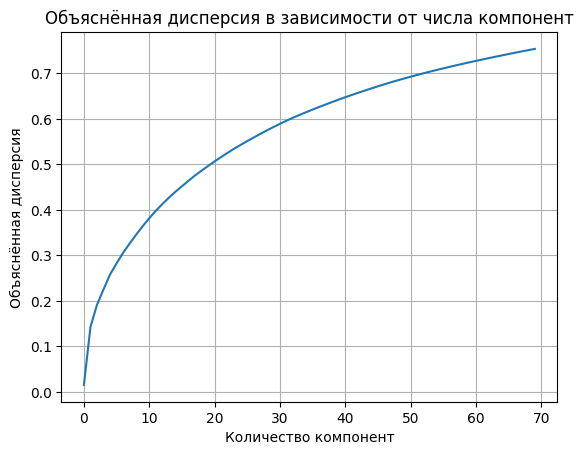

In [37]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Количество компонент')
plt.ylabel('Объяснённая дисперсия')
plt.title('Объяснённая дисперсия в зависимости от числа компонент')
plt.grid()
plt.show()

In [38]:
chunks_path = ""
n_chunks = 100
start, end = (0, 0)

for chunk_n in tqdm(range(n_chunks)):
    chunk_filepath = os.path.join(chunks_path, f"chunk_{chunk_n}.parquet")
    chunk = pl.read_parquet(chunk_filepath)

    end = start + len(chunk)

    chunk_feats = np.vstack(chunk['embedding'].to_list())
    reduced_chunk = reduced[start:end]

    full_embeds = np.hstack([reduced_chunk, chunk_feats])

    full_item_embeds = pl.DataFrame({
        'item_id': chunk['item_id'],
        'full_embed': list(full_embeds)
    })

    full_item_embeds.write_parquet(f"chunk_{chunk_n}.parquet")

    start = end

    del chunk, chunk_feats, full_embeds, full_item_embeds
    gc.collect()

100%|██████████| 100/100 [26:26<00:00, 15.87s/it]


In [39]:
def get_memory_usage():
    local_vars = list(locals().items())
    global_vars = list(globals().items())
    all_vars = local_vars + global_vars
    
    var_sizes = []
    for var_name, var_value in all_vars:
        if not var_name.startswith('_'):
            try:
                size = sys.getsizeof(var_value)
                if size > 1024:
                    var_sizes.append((var_name, size))
            except:
                pass
    
    var_sizes.sort(key=lambda x: x[1], reverse=True)
    
    for name, size in var_sizes[:20]:
        if size > 1024**3:
            print(f"{name}: {size/1024**3:.2f} GB")
        elif size > 1024**2:
            print(f"{name}: {size/1024**2:.2f} MB")
        elif size > 1024:
            print(f"{name}: {size/1024:.2f} KB")


get_memory_usage()

reduced: 1.65 GB
item_chunk: 320.00 MB
model_counts: 80.00 MB
model_zipf_devs: 80.00 MB
zipf_feats: 80.00 MB
rows: 37.26 MB
log_pop: 13.40 MB
sorted_freq: 13.40 MB
sorted_model_counts: 13.40 MB
mask: 4.39 MB
categories_tree: 1.66 MB
as_df: 74.09 KB
edges: 58.34 KB
apparel_categories: 32.21 KB
subtree_nodes: 32.21 KB
value_coords: 12.76 KB
target_nodes: 3.79 KB
attributes_set: 2.21 KB
tqdm: 1.65 KB
PoincareModel: 1.65 KB
